<a href="https://colab.research.google.com/github/Aryachavoshi/PINN-SM/blob/main/Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import time
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import RAdam
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import torch.nn.utils as nn_utils
from torch.utils.data import DataLoader, TensorDataset, random_split
from scipy.optimize import minimize
from scipy.stats import entropy
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)


##Reading the training dataset

In [3]:
training_df = pd.read_csv('training_for_transfer.csv')
del training_df['Unnamed: 0']

##Model classes. Models: PINN_SM, ANN, Traditional_PINN

In [4]:
class PINN_SM(nn.Module):
    def __init__(self):
        super(PINN_SM, self).__init__()
        # attention network
        self.attention_net = nn.Sequential(
            nn.Linear(6, 90),
            nn.Tanh(),
            nn.Linear(90, 10),
            nn.Sigmoid(),
        )
        # psi network
        self.psi_net = nn.Sequential(
            nn.Linear(16, 90),
            nn.Tanh(),
            nn.Linear(90, 90),
            nn.Tanh(),
            nn.Linear(90, 90),
            nn.Tanh(),
            nn.Linear(90, 90),
            nn.Tanh(),
            nn.Linear(90, 1)
        )
        # theta network
        self.theta_net = nn.Sequential(
            nn.Linear(1, 90),
            nn.Tanh(),
            nn.Linear(90, 1),
            nn.Sigmoid()
        )
        # K network
        self.K_net = nn.Sequential(
            nn.Linear(1, 90),
            nn.Tanh(),
            nn.Linear(90, 90),
            nn.Tanh(),
            nn.Linear(90, 1)
        )

        # Initialize the weights to be positive using Xavier initialization
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.psi_net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

        for m in self.theta_net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
                m.weight.data.clamp_(min=0)

        for m in self.K_net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
                m.weight.data.clamp_(min=0)
        for m in self.attention_net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
                m.weight.data.clamp_(min=0)
    # forward pass of the network
    def forward(self, inputs):

        attention_weights = self.attention_net(inputs[:, 0:6])
        new_R = inputs[:, 6:] * attention_weights
        inputs = torch.cat([inputs[:, 0:6], new_R], dim=-1)

        psi = -torch.exp(self.psi_net(inputs))
        K = torch.exp(self.K_net(-torch.log(-psi)))
        theta = self.theta_net(-torch.log(-psi))

        return psi,K,theta
# function defined to keep the theta network and k network positive
def enforce_positive_weights(model):
    for m in model.theta_net.modules():
        if isinstance(m, nn.Linear):
            m.weight.data.abs_()
            m.bias.data.abs_()
    for m in model.K_net.modules():
        if isinstance(m, nn.Linear):
            m.weight.data.abs_()
            m.bias.data.abs_()
def loss_function(model, inputs, theta):

    inputs.requires_grad = True
    psi,K,theta_pred = model(inputs)

   # Compute gradients with respect to inputs
    psi_z = torch.autograd.grad(psi, inputs, grad_outputs=torch.ones_like(psi), create_graph=True)[0][:, 1].unsqueeze(1)
    psi_zz = torch.autograd.grad(psi_z, inputs, grad_outputs=torch.ones_like(psi_z), create_graph=True)[0][:, 1].unsqueeze(1)
    theta_t = torch.autograd.grad(theta_pred, inputs, grad_outputs=torch.ones_like(theta_pred), create_graph=True)[0][:, 0].unsqueeze(1)
    K_z = torch.autograd.grad(K, inputs, grad_outputs=torch.ones_like(K), create_graph=True)[0][:, 1].unsqueeze(1)

    # PDE residual for the Richards-Richards equation
    r = theta_t - K_z * psi_z - K * psi_zz - K_z

    # Loss components
    data_fitting_loss = torch.mean(((theta_pred - theta) ** 2))
    pde_residual_loss = torch.mean(r ** 2)

    # Compute gradients with respect to model parameters
    data_fitting_grad = torch.autograd.grad(data_fitting_loss, model.parameters(), create_graph=True,allow_unused=True)
    pde_residual_grad = torch.autograd.grad(pde_residual_loss, model.parameters(), create_graph=True,allow_unused=True)

    # Calculate maximum gradient of PDE residual component
    max_grad_pde_residual = max(g.abs().max() for g in pde_residual_grad if g is not None)

    # Calculate average gradient of data-fitting component
    avg_grad_data_fitting = torch.mean(torch.stack([g.abs().mean() for g in data_fitting_grad if g is not None]))

    # Compute the ratio
    gradient_ratio = max_grad_pde_residual / avg_grad_data_fitting

    if gradient_ratio>1:

      total_loss = data_fitting_loss + (1/gradient_ratio)*pde_residual_loss
      #print('PDE RESIDUAL ADJUSTMENT')

    else:

      total_loss = data_fitting_loss + pde_residual_loss

    return total_loss
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        # attention network
        self.attention_net = nn.Sequential(
            nn.Linear(6, 90),
            nn.Tanh(),
            nn.Linear(90, 10),
            nn.Sigmoid(),
        )
        # psi network
        self.psi_net = nn.Sequential(
            nn.Linear(16, 90),
            nn.Tanh(),
            nn.Linear(90, 90),
            nn.Tanh(),
            nn.Linear(90, 90),
            nn.Tanh(),
            nn.Linear(90, 90),
            nn.Tanh(),
            nn.Linear(90, 1)
        )
        # theta network
        self.theta_net = nn.Sequential(
            nn.Linear(1, 90),
            nn.Tanh(),
            nn.Linear(90, 1),
            nn.Sigmoid()
        )
        # K network
        self.K_net = nn.Sequential(
            nn.Linear(1, 90),
            nn.Tanh(),
            nn.Linear(90, 90),
            nn.Tanh(),
            nn.Linear(90, 1)
        )

        # Initialize the weights to be positive using Xavier initialization
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.psi_net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

        for m in self.theta_net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
                m.weight.data.clamp_(min=0)

        for m in self.K_net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
                m.weight.data.clamp_(min=0)
        for m in self.attention_net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
                m.weight.data.clamp_(min=0)
    # forward pass of the network
    def forward(self, inputs):

        attention_weights = self.attention_net(inputs[:, 0:6])
        new_R = inputs[:, 6:] * attention_weights
        inputs = torch.cat([inputs[:, 0:6], new_R], dim=-1)

        psi = -torch.exp(self.psi_net(inputs))
        K = torch.exp(self.K_net(-torch.log(-psi)))
        theta = self.theta_net(-torch.log(-psi))

        return psi,K,theta
# function defined to keep the theta network and k network positive
def enforce_positive_weights(model):
    for m in model.theta_net.modules():
        if isinstance(m, nn.Linear):
            m.weight.data.abs_()
            m.bias.data.abs_()
    for m in model.K_net.modules():
        if isinstance(m, nn.Linear):
            m.weight.data.abs_()
            m.bias.data.abs_()
def loss_function(model, inputs, theta):

    inputs.requires_grad = True
    psi,K,theta_pred = model(inputs)


    # Loss components
    data_fitting_loss = torch.mean(((theta_pred - theta) ** 2))
    total_loss = data_fitting_loss
    return total_loss

### Traditional PINN

class Traditional_PINN(nn.Module):
    def __init__(self):
        super(Traditional_PINN, self).__init__()

        self.psi_net = nn.Sequential(
            nn.Linear(2, 90),
            nn.Tanh(),
            nn.Linear(90, 90),
            nn.Tanh(),
            nn.Linear(90, 90),
            nn.Tanh(),
            nn.Linear(90, 90),
            nn.Tanh(),
            nn.Linear(90, 1)
        )

        self.theta_net = nn.Sequential(
            nn.Linear(1, 90),
            nn.Tanh(),
            nn.Linear(90, 1),
            nn.Sigmoid()
        )

        self.K_net = nn.Sequential(
            nn.Linear(1, 90),
            nn.Tanh(),
            nn.Linear(90, 90),
            nn.Tanh(),
            nn.Linear(90, 1)
        )
        # Initialize the weights to be positive using Xavier initialization
        self._initialize_weights()

    def _initialize_weights(self):

        for m in self.psi_net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

        for m in self.theta_net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
                m.weight.data.clamp_(min=0)

        for m in self.K_net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
                m.weight.data.clamp_(min=0)

    def forward(self, inputs):

        psi = -torch.exp(self.psi_net(inputs[:,0:2]))
        K = torch.exp(self.K_net(-torch.log(-psi)))
        theta = self.theta_net(-torch.log(-psi))

        return psi,K,theta

def enforce_positive_weights(model):
    for m in model.theta_net.modules():
        if isinstance(m, nn.Linear):
            m.weight.data.abs_()
            m.bias.data.abs_()
    for m in model.K_net.modules():
        if isinstance(m, nn.Linear):
            m.weight.data.abs_()
            m.bias.data.abs_()
def loss_function(model, inputs, theta):

    inputs.requires_grad = True
    psi,K,theta_pred = model(inputs)

   # Compute gradients with respect to inputs
    psi_z = torch.autograd.grad(psi, inputs, grad_outputs=torch.ones_like(psi), create_graph=True)[0][:, 1].unsqueeze(1)
    psi_zz = torch.autograd.grad(psi_z, inputs, grad_outputs=torch.ones_like(psi_z), create_graph=True)[0][:, 1].unsqueeze(1)
    theta_t = torch.autograd.grad(theta_pred, inputs, grad_outputs=torch.ones_like(theta_pred), create_graph=True)[0][:, 0].unsqueeze(1)
    K_z = torch.autograd.grad(K, inputs, grad_outputs=torch.ones_like(K), create_graph=True)[0][:, 1].unsqueeze(1)

    # PDE residual for the Richards-Richards equation
    r = theta_t - K_z * psi_z - K * psi_zz - K_z

    # Loss components
    data_fitting_loss = torch.mean(((theta_pred - theta) ** 2))
    pde_residual_loss = torch.mean(r ** 2)

    # Compute gradients with respect to model parameters
    data_fitting_grad = torch.autograd.grad(data_fitting_loss, model.parameters(), create_graph=True,allow_unused=True)
    pde_residual_grad = torch.autograd.grad(pde_residual_loss, model.parameters(), create_graph=True,allow_unused=True)

    # Calculate maximum gradient of PDE residual component
    max_grad_pde_residual = max(g.abs().max() for g in pde_residual_grad if g is not None)

    # Calculate average gradient of data-fitting component
    avg_grad_data_fitting = torch.mean(torch.stack([g.abs().mean() for g in data_fitting_grad if g is not None]))

    # Compute the ratio
    gradient_ratio = max_grad_pde_residual / avg_grad_data_fitting

    if gradient_ratio>1:

      total_loss = data_fitting_loss + (1/gradient_ratio)*pde_residual_loss
      #print('PDE RESIDUAL ADJUSTMENT')

    else:

      total_loss = data_fitting_loss + pde_residual_loss

    return total_loss

## Training function definition

In [5]:
def train(model, optimizer, dataloader, test_loader, epochs):
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        num_batches = 0
        for batch_idx, (inputs_batch, theta_batch) in enumerate(dataloader):
            inputs_batch.to(device)
            theta_batch.to(device)
            optimizer.zero_grad()
            loss = loss_function(model, inputs_batch, theta_batch)
            if torch.isnan(loss).any() or torch.isinf(loss).any():
                print(f'Warning: Loss is NaN or Inf at epoch {epoch}, batch {batch_idx}')
                continue
            loss.backward()
            nn_utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            enforce_positive_weights(model)
            total_loss += loss.item()
            num_batches += 1
        average_loss = total_loss / num_batches
        print(f'Epoch {epoch}, Average Training Loss: {average_loss}')
        test_loss = 0
        num_batches_test = 0
        for batch_idx, (inputs_batch, theta_batch) in enumerate(test_loader):
          inputs_batch.to(device)
          theta_batch.to(device)
          loss = loss_function(model, inputs_batch, theta_batch)
          test_loss += loss.item()
          num_batches_test += 1
        average_loss = test_loss / num_batches_test
        print(f'Epoch {epoch}, Average Test Loss: {average_loss}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Training and test data preparation

In [6]:
scaler = StandardScaler()
input_data = training_df.values[:,0:16]
scaler = scaler.fit(input_data)
scaled_data = scaler.transform(input_data) #with normalization!
inputs = torch.tensor(scaled_data, dtype=torch.float32).to(device)
theta = torch.tensor(training_df.iloc[:,16].values, dtype=torch.float32, requires_grad=True).unsqueeze(1).to(device)
dataset = TensorDataset(inputs, theta)
# Define the split ratio
train_size = int(0.3 * len(dataset))
test_size = len(dataset) - train_size
# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
# Create DataLoaders for training and test sets
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

## Training phase

In [11]:
model_pinn = PINN_SM()
model_pinn.load_state_dict(torch.load('PINN-SM-2.pth'))
optimizer_pinn = optim.Adam(model_pinn.parameters(), lr=0.003)
train(model_pinn, optimizer_pinn, train_loader, test_loader, epochs=60)

<ipython-input-11-8572eb14614c>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_pinn.load_state_dict(torch.load('PINN-SM-2.pth'))


Epoch 0, Average Training Loss: 0.0016347400455800462
Epoch 0, Average Test Loss: 0.000488820832011381
Epoch 1, Average Training Loss: 0.00037159219983216564
Epoch 1, Average Test Loss: 0.0003172588751666531
Epoch 2, Average Training Loss: 0.0002534822448483916
Epoch 2, Average Test Loss: 0.0002427201279320086
Epoch 3, Average Training Loss: 0.00019721534735702944
Epoch 3, Average Test Loss: 0.0002232667013785154
Epoch 4, Average Training Loss: 0.0001719344801142741
Epoch 4, Average Test Loss: 0.0001915276464822692
Epoch 5, Average Training Loss: 0.00015024360102789972
Epoch 5, Average Test Loss: 0.00017284628733171343
Epoch 6, Average Training Loss: 0.00011817145239063715
Epoch 6, Average Test Loss: 0.00013738573779451343
Epoch 7, Average Training Loss: 0.00010681564162950963
Epoch 7, Average Test Loss: 0.00014988493117214048
Epoch 8, Average Training Loss: 9.87860383454834e-05
Epoch 8, Average Test Loss: 0.0001218919697234726
Epoch 9, Average Training Loss: 8.337959122941299e-05
Epoc

In [12]:
model_ann = ANN()
model_ann.load_state_dict(torch.load('ANN-2.pth'))
optimizer_ann = optim.Adam(model_ann.parameters(), lr=0.003)
train(model_ann, optimizer_ann, train_loader, test_loader, epochs=60)

<ipython-input-12-fb5740dc7f20>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ann.load_state_dict(torch.load('ANN-2.pth'))


Epoch 0, Average Training Loss: 0.0022939236892116125
Epoch 0, Average Test Loss: 0.0006847782236075981
Epoch 1, Average Training Loss: 0.0005311492290436231
Epoch 1, Average Test Loss: 0.00044683227837515955
Epoch 2, Average Training Loss: 0.00036682772263737183
Epoch 2, Average Test Loss: 0.0003573765543083225
Epoch 3, Average Training Loss: 0.0003013571569934794
Epoch 3, Average Test Loss: 0.00030236647604476235
Epoch 4, Average Training Loss: 0.0002639942746859963
Epoch 4, Average Test Loss: 0.00027496598585971895
Epoch 5, Average Training Loss: 0.00022933612960019395
Epoch 5, Average Test Loss: 0.0002583132027211832
Epoch 6, Average Training Loss: 0.00020078791060803246
Epoch 6, Average Test Loss: 0.00022401522382215657
Epoch 7, Average Training Loss: 0.00017886482080801307
Epoch 7, Average Test Loss: 0.0001843285880686776
Epoch 8, Average Training Loss: 0.00016108054216049282
Epoch 8, Average Test Loss: 0.00016473920486928165
Epoch 9, Average Training Loss: 0.00015929037162774727

## Testing phase

In [13]:
all_inputs = []
all_true_theta = []
all_predicted_theta_pinn = []
all_predicted_theta_ann = []

# Iterate over all batches
model_pinn.eval()
model_ann.eval()
with torch.no_grad():
    for batch_id, (x, actual_theta) in enumerate(test_loader):
        # Compute true and predicted values
        true_theta = actual_theta.cpu().numpy()
        _, _, theta_pred_pinn = model_pinn(x)
        _, _, theta_pred_ann = model_ann(x)

        theta_pred_pinn = theta_pred_pinn.cpu().numpy()
        theta_pred_ann = theta_pred_ann.cpu().numpy()

        all_true_theta.append(true_theta)
        all_predicted_theta_pinn.append(theta_pred_pinn)
        all_predicted_theta_ann.append(theta_pred_ann)
        x = x.cpu().numpy()
        all_inputs.append(scaler.inverse_transform(x))

#all_inputs = np.concatenate(all_inputs, axis=0)
all_true_theta = np.concatenate(all_true_theta, axis=0)
all_predicted_theta_pinn = np.concatenate(all_predicted_theta_pinn, axis=0)
all_predicted_theta_ann = np.concatenate(all_predicted_theta_ann, axis=0)
all_inputs = np.concatenate(all_inputs, axis=0)

testdf = np.zeros((all_inputs.shape[0], all_inputs.shape[1] + 3))
testdf[:, :all_inputs.shape[1]] = all_inputs
testdf[:, all_inputs.shape[1]] = all_true_theta.squeeze()
testdf[:, all_inputs.shape[1] + 1] = all_predicted_theta_pinn.squeeze()
testdf[:, all_inputs.shape[1] + 2] = all_predicted_theta_ann.squeeze()

training_df_columns = training_df.columns[0:16]
column_names = list(training_df_columns) + ['true_theta', 'pinnpred','annpred']
testdf = pd.DataFrame(testdf, columns=column_names)
testdf = testdf.sort_values(by='t')
testdf.set_index(np.round(testdf['t'].values).astype(int),inplace=True)
z1 = testdf.loc[testdf['z']<0.31,]
z2 = testdf.loc[(testdf['z']>0.4)&(testdf['z']<0.57),]
z3 = testdf.loc[testdf['z']>0.75,]

## Testing phase over the whole test data (RMSE and R2 comparison of different models + vizualization)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'roo

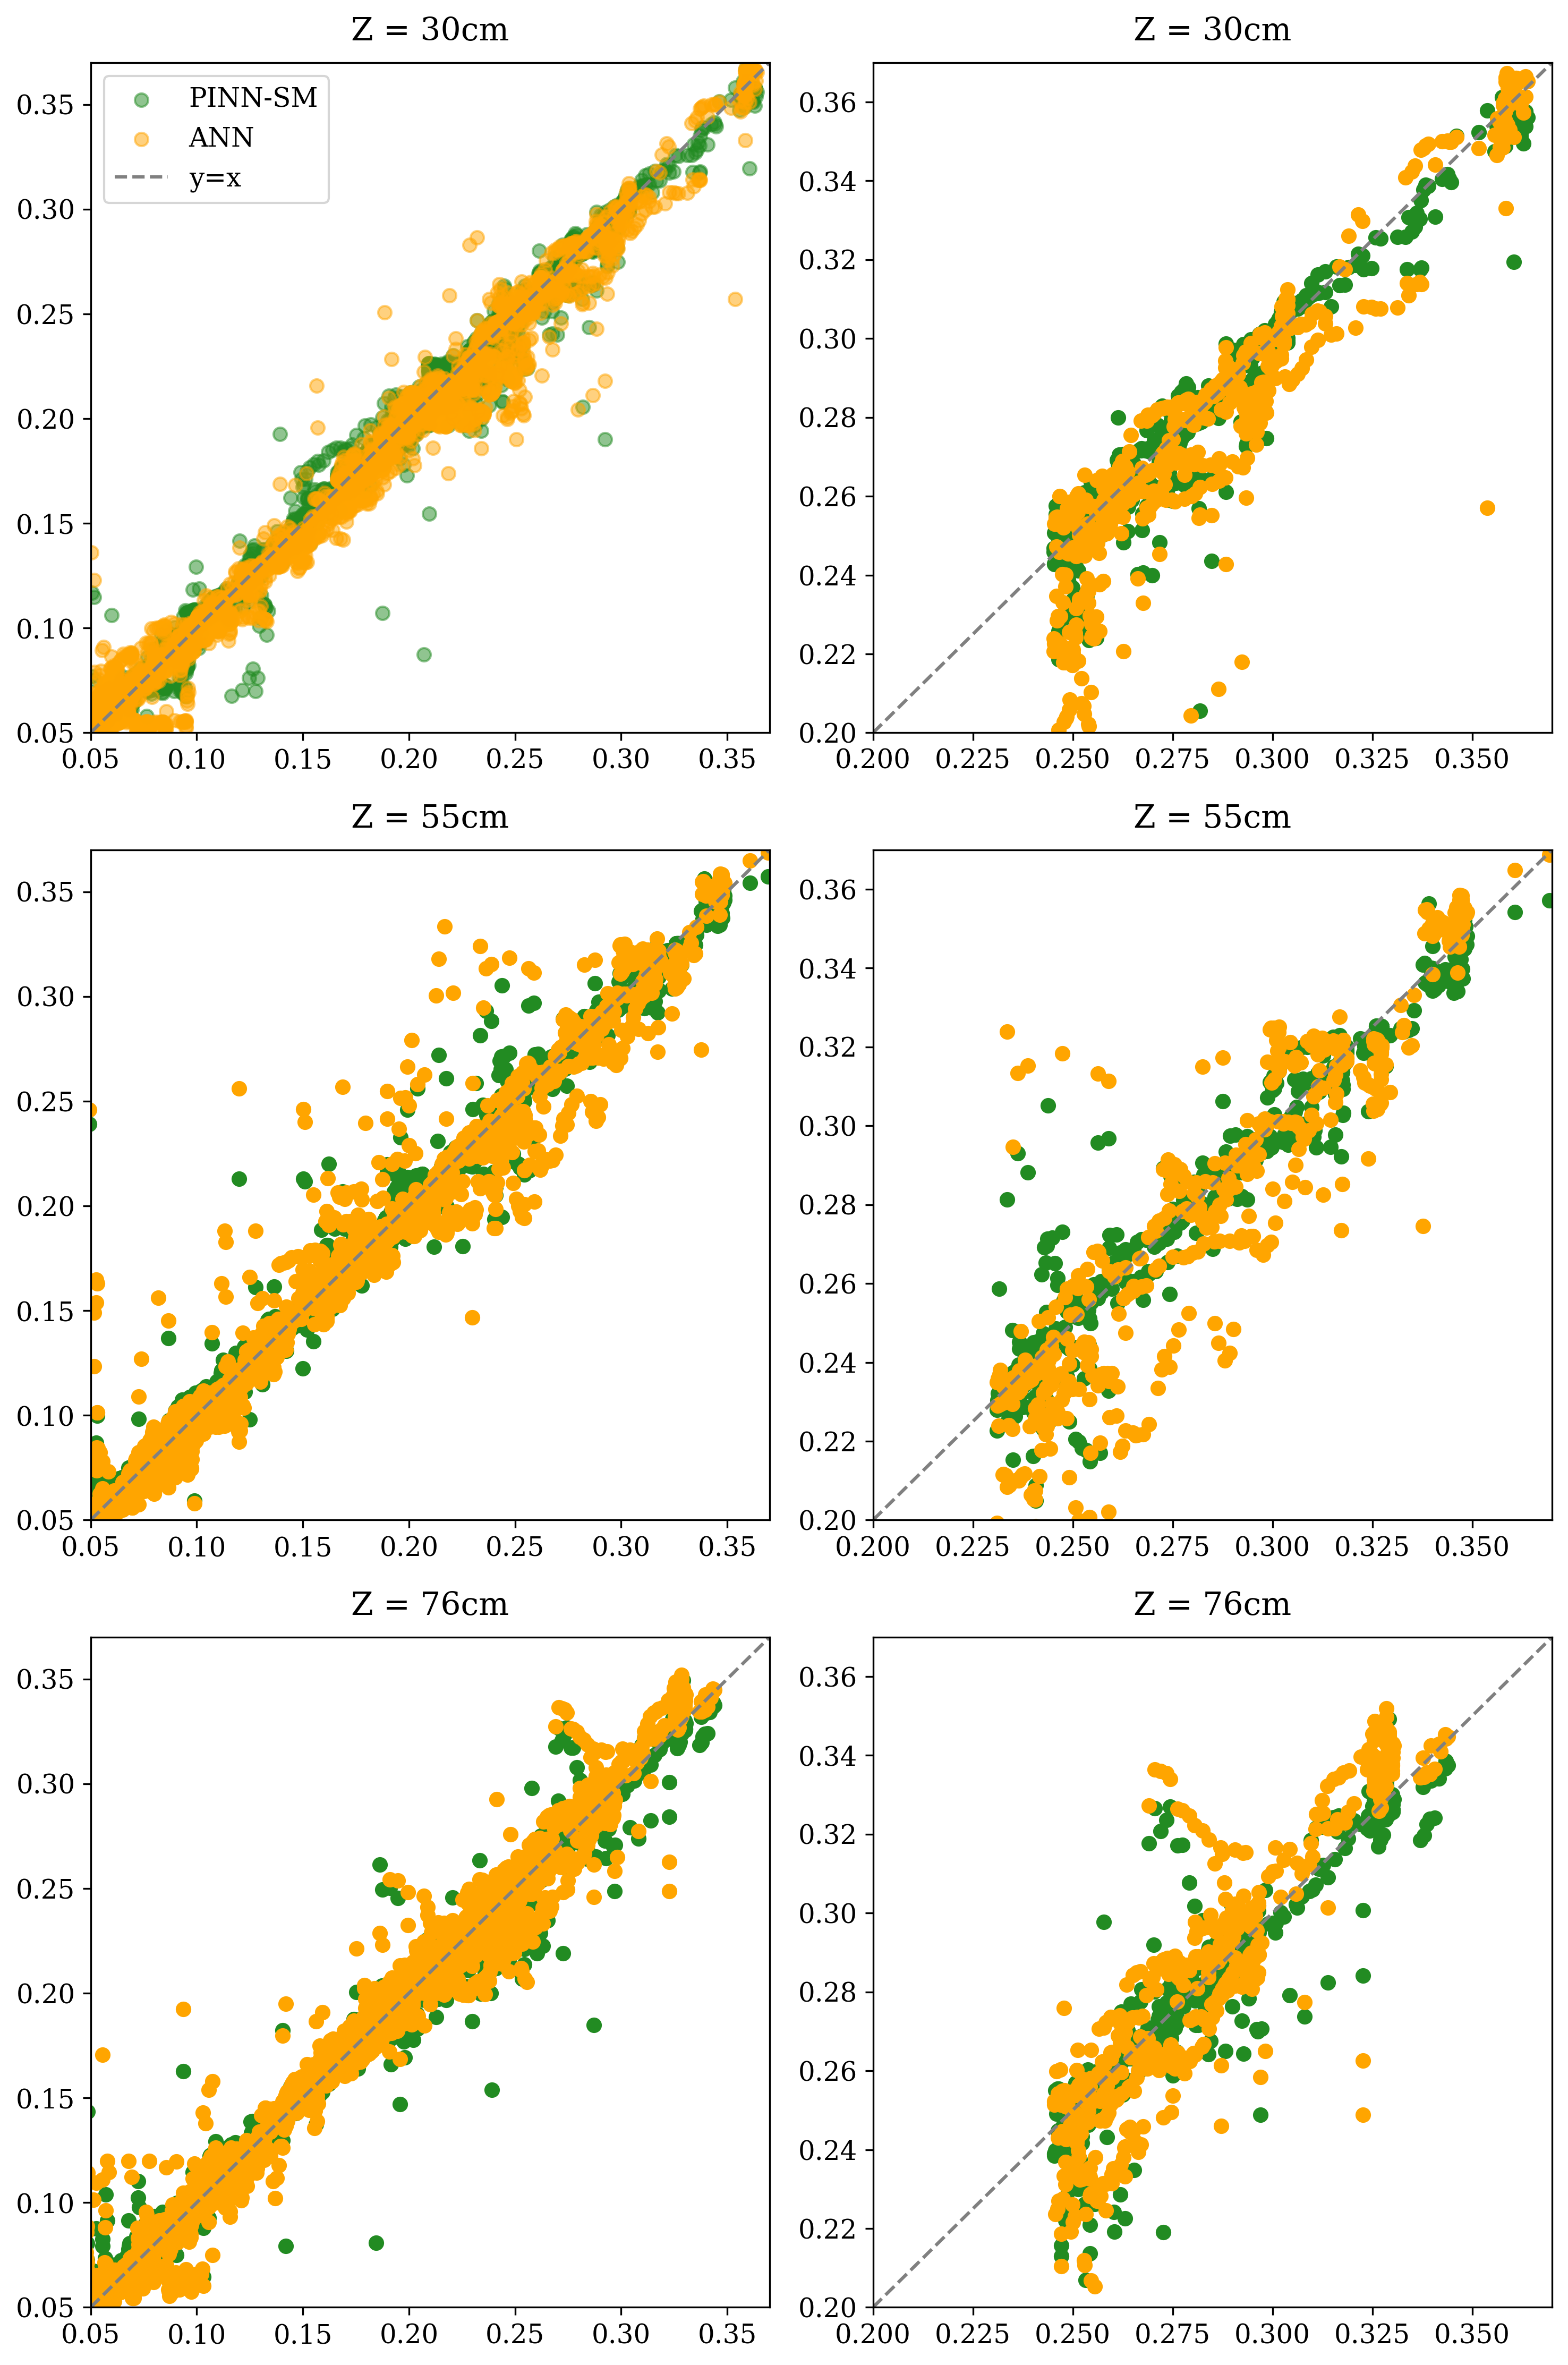


Performance Metrics Summary:

Full Dataset Analysis:
----------------------
Z = 30cm:
PINN-SM Performance: RMSE = 0.006, R² = 0.994
ANN Performance: RMSE = 0.009, R² = 0.987

Z = 55cm:
PINN-SM Performance: RMSE = 0.008, R² = 0.990
ANN Performance: RMSE = 0.011, R² = 0.981

Z = 76cm:
PINN-SM Performance: RMSE = 0.007, R² = 0.993
ANN Performance: RMSE = 0.009, R² = 0.986

Peak Values Analysis (90th percentile):
------------------------------------
Z = 30cm:
PINN-SM Performance: RMSE = 0.009, R² = 0.932
ANN Performance: RMSE = 0.015, R² = 0.814

Z = 55cm:
PINN-SM Performance: RMSE = 0.017, R² = 0.842
ANN Performance: RMSE = 0.018, R² = 0.830

Z = 76cm:
PINN-SM Performance: RMSE = 0.011, R² = 0.829
ANN Performance: RMSE = 0.016, R² = 0.676


In [16]:
# Set global font to serif with size 12
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

fig, ax = plt.subplots(3, 2, figsize=(10, 15), dpi=300)

# First column - Full dataset
# Z1 comparison
truez1 = z1['true_theta'].values
pinnz1 = z1['pinnpred'].values
annz1 = z1['annpred'].values

pinnz1rmse = mean_squared_error(truez1, pinnz1, squared=False)
pinnz1r2 = r2_score(truez1, pinnz1)
annz1rmse = mean_squared_error(truez1, annz1, squared=False)
annz1r2 = r2_score(truez1, annz1)


# Get limits for each subplot

ax[0,0].scatter(truez1, pinnz1, label='PINN-SM', color='forestgreen',alpha=0.5)
ax[0,0].scatter(truez1, annz1, label='ANN', color='orange',alpha=0.5)

ax[0,0].plot([0.05, 0.37], [0.05, 0.37], '--', color='gray', label='y=x')
ax[0,0].set_xlim(0.05, 0.37)
ax[0,0].set_ylim(0.05, 0.37)
ax[0,0].legend()

# Z2 comparison
truez2 = z2['true_theta'].values
pinnz2 = z2['pinnpred'].values
annz2 = z2['annpred'].values

pinnz2rmse = mean_squared_error(truez2, pinnz2, squared=False)
pinnz2r2 = r2_score(truez2, pinnz2)
annz2rmse = mean_squared_error(truez2, annz2, squared=False)
annz2r2 = r2_score(truez2, annz2)

ax[1,0].scatter(truez2, pinnz2, label='PINN-SM', color='forestgreen')
ax[1,0].scatter(truez2, annz2, label='ANN', color='orange')
ax[1,0].plot([0.05, 0.37], [0.05, 0.37], '--', color='gray', label='y=x')
ax[1,0].set_xlim(0.05, 0.37)
ax[1,0].set_ylim(0.05, 0.37)
#ax[1,0].legend()

# Z3 comparison
truez3 = z3['true_theta'].values
pinnz3 = z3['pinnpred'].values
annz3 = z3['annpred'].values

pinnz3rmse = mean_squared_error(truez3, pinnz3, squared=False)
pinnz3r2 = r2_score(truez3, pinnz3)
annz3rmse = mean_squared_error(truez3, annz3, squared=False)
annz3r2 = r2_score(truez3, annz3)


ax[2,0].scatter(truez3, pinnz3, label='PINN-SM', color='forestgreen')
ax[2,0].scatter(truez3, annz3, label='ANN', color='orange')
ax[2,0].plot([0.05, 0.37], [0.05, 0.37], '--', color='gray', label='y=x')
ax[2,0].set_xlim(0.05, 0.37)
ax[2,0].set_ylim(0.05, 0.37)
#ax[2,0].legend()

# Calculate percentiles
Q1 = np.percentile(z1['true_theta'].values, 90)
Q2 = np.percentile(z2['true_theta'].values, 90)
Q3 = np.percentile(z3['true_theta'].values, 90)

# Filter peak data
peakz1 = z1[z1['true_theta']>=Q1]
peakz2 = z2[z2['true_theta']>=Q2]
peakz3 = z3[z3['true_theta']>=Q3]

# Second column - Peak values
# Z1 peak comparison
truez1_peak = peakz1['true_theta'].values
pinnz1_peak = peakz1['pinnpred'].values
annz1_peak = peakz1['annpred'].values
pinnz1rmse_peak = mean_squared_error(truez1_peak, pinnz1_peak, squared=False)
pinnz1r2_peak = r2_score(truez1_peak, pinnz1_peak)
annz1rmse_peak = mean_squared_error(truez1_peak, annz1_peak, squared=False)
annz1r2_peak = r2_score(truez1_peak, annz1_peak)


ax[0,1].scatter(truez1_peak, pinnz1_peak, label='PINN-SM', color='forestgreen')
ax[0,1].scatter(truez1_peak, annz1_peak, label='ANN', color='orange')
ax[0,1].plot([0.2,0.37], [0.2,0.37], '--', color='gray', label='y=x')
ax[0,1].set_xlim(0.2,0.37)
ax[0,1].set_ylim(0.2,0.37)
#ax[0,1].legend()

# Z2 peak comparison
truez2_peak = peakz2['true_theta'].values
pinnz2_peak = peakz2['pinnpred'].values
annz2_peak = peakz2['annpred'].values

pinnz2rmse_peak = mean_squared_error(truez2_peak, pinnz2_peak, squared=False)
pinnz2r2_peak = r2_score(truez2_peak, pinnz2_peak)
annz2rmse_peak = mean_squared_error(truez2_peak, annz2_peak, squared=False)
annz2r2_peak = r2_score(truez2_peak, annz2_peak)



ax[1,1].scatter(truez2_peak, pinnz2_peak, label='PINN-SM', color='forestgreen')
ax[1,1].scatter(truez2_peak, annz2_peak, label='ANN', color='orange')
ax[1,1].plot([0.2,0.37], [0.2,0.37], '--', color='gray', label='y=x')
ax[1,1].set_xlim(0.2,0.37)
ax[1,1].set_ylim(0.2,0.37)
#ax[1,1].legend()

# Z3 peak comparison
truez3_peak = peakz3['true_theta'].values
pinnz3_peak = peakz3['pinnpred'].values
annz3_peak = peakz3['annpred'].values
pinnz3rmse_peak = mean_squared_error(truez3_peak, pinnz3_peak, squared=False)
pinnz3r2_peak = r2_score(truez3_peak, pinnz3_peak)
annz3rmse_peak = mean_squared_error(truez3_peak, annz3_peak, squared=False)
annz3r2_peak = r2_score(truez3_peak, annz3_peak)

ax[2,1].scatter(truez3_peak, pinnz3_peak, label='PINN-SM', color='forestgreen')
ax[2,1].scatter(truez3_peak, annz3_peak, label='ANN', color='orange')
ax[2,1].plot([0.2,0.37], [0.2,0.37], '--', color='gray', label='y=x')
ax[2,1].set_xlim(0.2,0.37)
ax[2,1].set_ylim(0.2,0.37)
#ax[2,1].legend()

# Add titles for the columns and rows
ax[0,0].set_title('Z = 30cm', pad=10)
ax[0,1].set_title('Z = 30cm', pad=10)

ax[1,0].set_title('Z = 55cm', pad=10)
ax[1,1].set_title('Z = 55cm', pad=10)

ax[2,0].set_title('Z = 76cm', pad=10)
ax[2,1].set_title('Z = 76cm', pad=10)

# Adjust layout
plt.tight_layout()
plt.show()

# Print performance metrics with descriptions
print("\nPerformance Metrics Summary:")
print("\nFull Dataset Analysis:")
print("----------------------")
print("Z = 30cm:")
print(f"PINN-SM Performance: RMSE = {pinnz1rmse:.3f}, R² = {pinnz1r2:.3f}")
print(f"ANN Performance: RMSE = {annz1rmse:.3f}, R² = {annz1r2:.3f}")

print("\nZ = 55cm:")
print(f"PINN-SM Performance: RMSE = {pinnz2rmse:.3f}, R² = {pinnz2r2:.3f}")
print(f"ANN Performance: RMSE = {annz2rmse:.3f}, R² = {annz2r2:.3f}")


print("\nZ = 76cm:")
print(f"PINN-SM Performance: RMSE = {pinnz3rmse:.3f}, R² = {pinnz3r2:.3f}")
print(f"ANN Performance: RMSE = {annz3rmse:.3f}, R² = {annz3r2:.3f}")


print("\nPeak Values Analysis (90th percentile):")
print("------------------------------------")
print("Z = 30cm:")
print(f"PINN-SM Performance: RMSE = {pinnz1rmse_peak:.3f}, R² = {pinnz1r2_peak:.3f}")
print(f"ANN Performance: RMSE = {annz1rmse_peak:.3f}, R² = {annz1r2_peak:.3f}")


print("\nZ = 55cm:")
print(f"PINN-SM Performance: RMSE = {pinnz2rmse_peak:.3f}, R² = {pinnz2r2_peak:.3f}")
print(f"ANN Performance: RMSE = {annz2rmse_peak:.3f}, R² = {annz2r2_peak:.3f}")

print("\nZ = 76cm:")
print(f"PINN-SM Performance: RMSE = {pinnz3rmse_peak:.3f}, R² = {pinnz3r2_peak:.3f}")
print(f"ANN Performance: RMSE = {annz3rmse_peak:.3f}, R² = {annz3r2_peak:.3f}")



## Testing phase over the whole test data (Histogram Vizualization + KL divergence + P(>0.99))

In [ ]:
def calculate_kl_divergence(p, q, bins=50):
    # Calculate histogram for both distributions
    p_hist, bin_edges = np.histogram(p, bins=bins, density=True)
    q_hist, _ = np.histogram(q, bins=bin_edges, density=True)

    # Add a small constant to avoid division by zero
    epsilon = 1e-10
    p_hist = p_hist + epsilon
    q_hist = q_hist + epsilon

    # Normalize
    p_hist = p_hist / np.sum(p_hist)
    q_hist = q_hist / np.sum(q_hist)

    # Calculate KL divergence
    kl_div = entropy(p_hist, q_hist)
    return kl_div

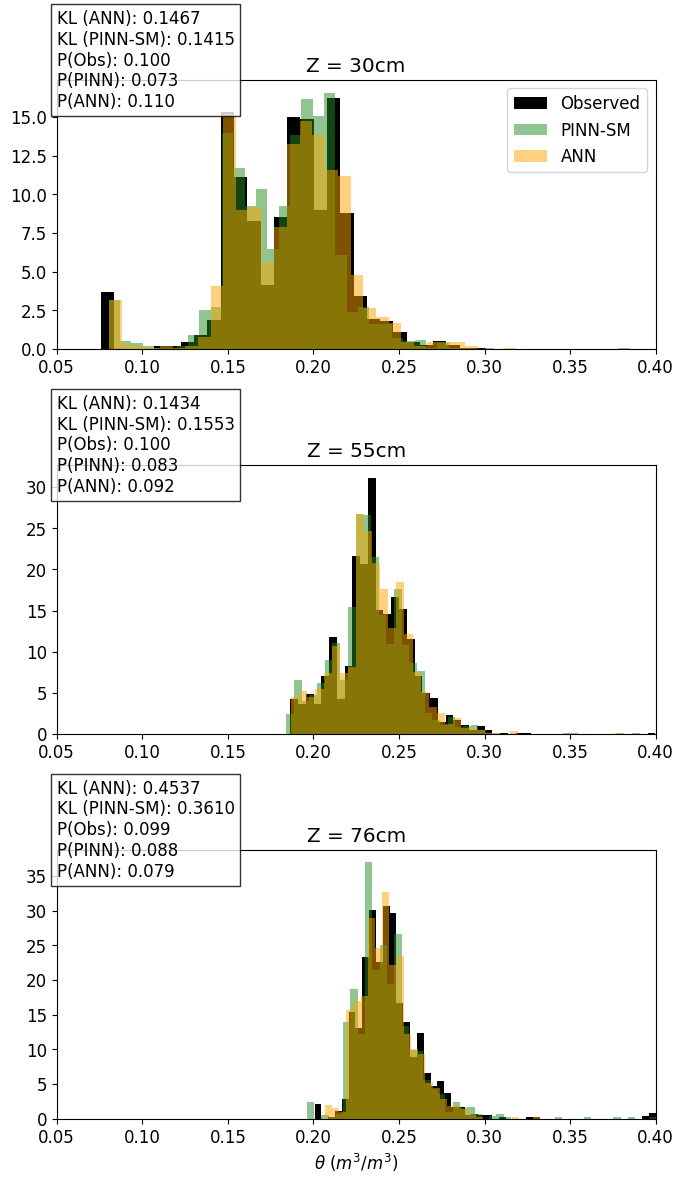

In [ ]:
plt.rcParams.update({'font.size': 12})  # Set global font size to 12
fig, ax = plt.subplots(3, 1, figsize=(7, 12))

# First subplot (Z = 30cm)
ax[0].hist(z1['true_theta'], bins=50, alpha=1, label='Observed', density=True, color='black')
ax[0].hist(z1['pinnpred'], bins=50, alpha=0.5, label='PINN-SM', density=True, color='forestgreen')
ax[0].hist(z1['annpred'], bins=50, alpha=0.5, label='ANN', density=True, color='orange')
ax[0].set_xlim(0.05, 0.4)
ax[0].legend()
ax[0].set_title('Z = 30cm')
# Add KL divergence and probability text
kl_ann1 = calculate_kl_divergence(z1['true_theta'], z1['annpred'])
kl_pinn1 = calculate_kl_divergence(z1['true_theta'], z1['pinnpred'])
prob_true1 = (z1['true_theta']>Q1).sum()/(len(z1['true_theta']))
prob_pinn1 = (z1['pinnpred']>Q1).sum()/(len(z1['pinnpred']))
prob_ann1 = (z1['annpred']>Q1).sum()/(len(z1['annpred']))
ax[0].text(0.05, ax[0].get_ylim()[1]*0.9,
           f'KL (ANN): {kl_ann1:.4f}\nKL (PINN-SM): {kl_pinn1:.4f}\n' +
           f'P(Obs): {prob_true1:.3f}\nP(PINN): {prob_pinn1:.3f}\nP(ANN): {prob_ann1:.3f}',
           bbox=dict(facecolor='white', alpha=0.8))

# Second subplot (Z = 55cm)
ax[1].hist(z2['true_theta'], bins=50, alpha=1, label='Observed', density=True, color='black')
ax[1].hist(z2['pinnpred'], bins=50, alpha=0.5, label='PINN-SM', density=True, color='forestgreen')
ax[1].hist(z2['annpred'], bins=50, alpha=0.5, label='ANN', density=True, color='orange')
ax[1].set_xlim(0.05, 0.4)
ax[1].set_title('Z = 55cm')
# Add KL divergence and probability text
kl_ann2 = calculate_kl_divergence(z2['true_theta'], z2['annpred'])
kl_pinn2 = calculate_kl_divergence(z2['true_theta'], z2['pinnpred'])
prob_true2 = (z2['true_theta']>Q2).sum()/(len(z2['true_theta']))
prob_pinn2 = (z2['pinnpred']>Q2).sum()/(len(z2['pinnpred']))
prob_ann2 = (z2['annpred']>Q2).sum()/(len(z2['annpred']))
ax[1].text(0.05, ax[1].get_ylim()[1]*0.9,
           f'KL (ANN): {kl_ann2:.4f}\nKL (PINN-SM): {kl_pinn2:.4f}\n' +
           f'P(Obs): {prob_true2:.3f}\nP(PINN): {prob_pinn2:.3f}\nP(ANN): {prob_ann2:.3f}',
           bbox=dict(facecolor='white', alpha=0.8))

# Third subplot (Z = 76cm)
ax[2].hist(z3['true_theta'], bins=50, alpha=1, label='Observed', density=True, color='black')
ax[2].hist(z3['pinnpred'], bins=50, alpha=0.5, label='PINN-SM', density=True, color='forestgreen')
ax[2].hist(z3['annpred'], bins=50, alpha=0.5, label='ANN', density=True, color='orange')
ax[2].set_xlim(0.05, 0.4)
ax[2].set_title('Z = 76cm')
ax[2].set_xlabel(r'$\theta$ $(m^3/m^3)$')
# Add KL divergence and probability text
kl_ann3 = calculate_kl_divergence(z3['true_theta'], z3['annpred'])
kl_pinn3 = calculate_kl_divergence(z3['true_theta'], z3['pinnpred'])
prob_true3 = (z3['true_theta']>Q3).sum()/(len(z3['true_theta']))
prob_pinn3 = (z3['pinnpred']>Q3).sum()/(len(z3['pinnpred']))
prob_ann3 = (z3['annpred']>Q3).sum()/(len(z3['annpred']))
ax[2].text(0.05, ax[2].get_ylim()[1]*0.9,
           f'KL (ANN): {kl_ann3:.4f}\nKL (PINN-SM): {kl_pinn3:.4f}\n' +
           f'P(Obs): {prob_true3:.3f}\nP(PINN): {prob_pinn3:.3f}\nP(ANN): {prob_ann3:.3f}',
           bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()